# Homework Assignment 4 - Deep Learning 1: Neural Networks
### **Due:** Sunday, May 28, 11:59pm
### Total: 100 points

## Import all the libraries and tools you need below.

In [91]:
import os

os.getcwd()
os.chdir("C:\Data")
os.getcwd()

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import pandas as pd
import numpy as np 
from numpy import log,dot,e,shape
from numpy import log,dot,e,shape
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.special import softmax

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import silhouette_score

from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import check_cv
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs, make_circles

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.layers import Input
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras import losses 
from keras import optimizers 
from keras import metrics

## **1)** The Forward Phase (20 points)

Before creating Neural Networks with Keras, this question needs your conceptual/theoretical understanding on how a Neural Networks works. Revisiting the annotated Neural Network slides (Lec8) should be helpful.

Write a user-defined function called **forward_phase_classification**. It takes three inputs: data, weights at all layers and biases at all layers. You can see the input format in the toy data created below. The function should return the class probabilities for all the instances as a matrix output. **The function cannot assume a fixed number of layers or a fixed number of nodes at any layer. It should figure those out from the given inputs.**

- Start with assigning the transpose of the data to an A variable.

- Create a loop, each iteration will be a layer of the network.
    - For each layer, you need the A matrix from the previous layer, the weights of the layer and the bias of the layer. Using them, calculate the Z matrix of the layer.
    - Using Z and a non-linear function, calculate the A matrix of the layer.
        - The non-linear function should be **ReLU** for hidden layers and **softmax** for the output layer. You can either implement them in the loop or create separate user-defined functions for them. (I recommend the second option, it keeps the code clean.)
    - After the loop is over, return the last A matrix.
    
You can use the last two lines below to see if your function is working. You should see class 0, 1, and 2 probabilities for all 10,000 instances. The class 1 probability should always be very close to 1.

In [2]:
np.random.seed(1)
random_weights = [np.random.rand(20,8), np.random.rand(10,20), np.random.rand(5,10), np.random.rand(3,5)]
random_biases = [np.random.rand(20,1), np.random.rand(10,1), np.random.rand(5,1), np.random.rand(3,1)]

random_feature_matrix = np.random.rand(1000,8)

In [3]:
################## Write your function here #####################

def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=0)

def forward_phase_classification(data, weights, biases):
    A = data.T
    num_layers = len(weights)
    
    for i in range(num_layers):
        Z = np.dot(weights[i], A) + biases[i]
        
        if i == num_layers - 1:
            A = softmax(Z)
        else:
            A = relu(Z)
    
    return A.T


probs = forward_phase_classification(random_feature_matrix, random_weights, random_biases)
pd.DataFrame(probs)

,0,1,2
0,9.977979e-07,0.999999,1.510224e-136
1,3.172698e-06,0.999997,8.061166e-124
2,2.182755e-06,0.999998,5.477623e-128
3,1.634862e-05,0.999984,7.997921e-109
4,8.895328e-07,0.999999,5.007796e-134
...,...,...,...
995,6.877432e-06,0.999993,7.636280e-116
996,1.706221e-05,0.999983,1.966894e-104
997,6.038873e-06,0.999994,2.495159e-115
998,7.063293e-06,0.999993,4.116998e-116


## **2)** Classification with Neural Networks (30 points)

In this question, you need to create a neural network that classifies different cardiac arrhythmias. An arrhythmia is the human heart beating irregularly, due to different conditions on the cardiac tissue. Conditions on different spots on the cardiac tissue creates different types of arrhythmias.

Run the code below. It uploads **heartbeat_dataset.csv** where each row is a heartbeat signal from a patient. All the columns except the last one are the values in the signal. The last column is 0 if the patient is healthy and 1, 2, 3 or 4 if the patient has one of the different arrhythmia types. Five different classes in this dataset need a 5-class classification task.

The code below plots what a heartbeat looks like. It also downsamples class 0, which is in vast majority, to make high accuracy values meaningful. After that, it creates the training and test datasets, along with some more preprocessing.

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64
0.0    8000
4.0    6431
2.0    5788
1.0    2223
3.0     641
Name: 187, dtype: int64
(20774, 187)


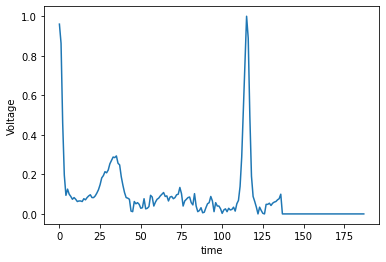

In [63]:
data = pd.read_csv('heartbeat_dataset.csv', header=None)
#data=pd.DataFrame(data)

# One heartbeat
plt.plot(data.iloc[1,:])
plt.xlabel('time')
plt.ylabel('Voltage')
plt.plot()

# Overall class distribution
print(data[187].value_counts())

# Downsampling Class 0 instances to 8000
class_other = data[data[187]!=0.0]
class_0 = data[data[187]==0.0].sample(n = 8000, random_state=1)
data_sampled = pd.concat([class_0, class_other])

# The new class distribution.
print(data_sampled[187].value_counts())

# Separating the features and the labels into X and y variables.
y = data_sampled[187]
X = data_sampled.drop([187], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1, test_size=0.1)

print(X_train.shape)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [61]:
#X_train.shape
#X_test.shape
#y_test.shape
#y_train.shape

(2309, 187)

Create a Neural Network for the 5-class classification task. 

Compile the network using the proper cost function and an optimizer of your choice. **(3 points)** Don't forget to set the number of epochs and other necessary inputs while training. **(5 points)** Assign your training line to a history output. **(2 points)** **Use a random seed for reproducible results.** **(2 points)**

After the network is trained, print the test accuracy **(3 points)** and the confusion matrix **(3 points)**, and plot both the training and validation losses against the number of epochs. **(2 points)**

The entire architecture and the training inputs are your choice. **Your network should return a test accuracy higher than 94%.** **(10 points)**

In [66]:
# Set a random seed for reproducible results
np.random.seed(17)
tf.random.set_seed(17)

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(187,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model with categorical_crossentropy as the loss function
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model and store the training history
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    verbose=1)

Epoch 1/30
  4/650 [..............................] - ETA: 11s - loss: 1.5782 - accuracy: 0.3047

C:\Users\dylan\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


650/650 [==============================] - 11s 16ms/step - loss: 0.6571 - accuracy: 0.7637 - val_loss: 0.4555 - val_accuracy: 0.8502
Epoch 2/30
650/650 [==============================] - 11s 17ms/step - loss: 0.3916 - accuracy: 0.8694 - val_loss: 0.3572 - val_accuracy: 0.8826
Epoch 3/30
650/650 [==============================] - 11s 16ms/step - loss: 0.3282 - accuracy: 0.8902 - val_loss: 0.3312 - val_accuracy: 0.8891
Epoch 4/30
650/650 [==============================] - 11s 16ms/step - loss: 0.2908 - accuracy: 0.9005 - val_loss: 0.2990 - val_accuracy: 0.9013
Epoch 5/30
650/650 [==============================] - 11s 17ms/step - loss: 0.2696 - accuracy: 0.9089 - val_loss: 0.2835 - val_accuracy: 0.9065
Epoch 6/30
650/650 [==============================] - 11s 16ms/step - loss: 0.2489 - accuracy: 0.9150 - val_loss: 0.2705 - val_accuracy: 0.9138
Epoch 7/30
650/650 [==============================] - 11s 16ms/step - loss: 0.2357 - accuracy: 0.9205 - val_loss: 0.2590 - val_accuracy: 0.9186
Epo

73/73 [==============================] - 0s 2ms/step
Test Accuracy: 94.11%
Confusion Matrix:
[[767  13   9   7   4]
 [ 34 178   6   3   2]
 [ 21   2 543   8   5]
 [  9   0   3  51   1]
 [  5   1   2   1 634]]


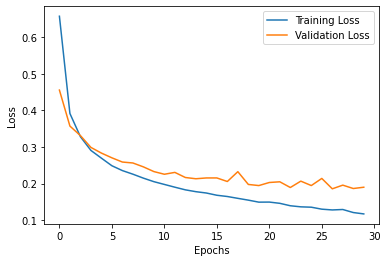

In [67]:
# Evaluate the model on the test set to get the accuracy
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test_original = np.argmax(y_test_encoded, axis=-1)
test_accuracy = accuracy_score(y_test_original, y_pred)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Create a confusion matrix
cm = confusion_matrix(y_test_original, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot the training and validation losses against the number of epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **3)** Regression with Neural Networks (35 points)

In this question, you need to create a neural network that predicts the critical temperature of a material, given its 81 chemical features. The critical temperature (in Kelvin) of a material is where the material starts to show superconductivity characteristics, a very important field of research at the intersection of chemistry, material science, and solid-state physics.

Upload the **superconductivity.csv** file. **(2 points)** Each row is a material and the first 81 columns are the features. The last column is the critical temperature, which is the regression target value. Create the feature matrix and the target column. **(2 points)** Create the training and test sets with a 70-30 split. (Use **random_state=2**) **(2 points)** Scale the training and test features. **(2 points)**

Create a Neural Network for the regression task. 

Compile the network using one of the proper cost functions and an optimizer of your choice. **(3 points)** Don't forget to set the number of epochs and other necessary inputs while training. **(5 points)** Assign your training line to a history output. **(2 points)** **Use a random seed for reproducible results.** **(2 points)**

After the network is trained, print the test RMSE **(3 points)** and plot both the training and validation losses against the number of epochs. **(2 points)**

The entire architecture and the training inputs are your choice. **Your network should return an RMSE lower than 14 K.** **(10 points)**

In [70]:
# Set a random seed for reproducible results
np.random.seed(2)
tf.random.set_seed(2)

data = pd.read_csv('superconductivity.csv')

features = data.drop('critical_temp', axis=1) 
target = data['critical_temp']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=2)

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=30, 
                    batch_size=32, 
                    verbose=1)

Epoch 1/30
  5/466 [..............................] - ETA: 6s - loss: 2796.5405 

C:\Users\dylan\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


466/466 [==============================] - 7s 15ms/step - loss: 735.0308 - val_loss: 334.9114
Epoch 2/30
466/466 [==============================] - 7s 15ms/step - loss: 298.7731 - val_loss: 285.9204
Epoch 3/30
466/466 [==============================] - 7s 16ms/step - loss: 261.3404 - val_loss: 270.3483
Epoch 4/30
466/466 [==============================] - 7s 15ms/step - loss: 245.7491 - val_loss: 255.7378
Epoch 5/30
466/466 [==============================] - 7s 15ms/step - loss: 236.4607 - val_loss: 248.8230
Epoch 6/30
466/466 [==============================] - 7s 15ms/step - loss: 228.3933 - val_loss: 244.1746
Epoch 7/30
466/466 [==============================] - 7s 15ms/step - loss: 222.8892 - val_loss: 234.4874
Epoch 8/30
466/466 [==============================] - 7s 16ms/step - loss: 217.4810 - val_loss: 235.5612
Epoch 9/30
466/466 [==============================] - 7s 15ms/step - loss: 212.9247 - val_loss: 226.3979
Epoch 10/30
466/466 [==============================] - 7s 15ms/ste

200/200 [==============================] - 0s 2ms/step
Test RMSE: 13.86118271560153


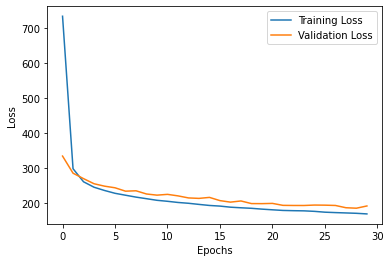

In [73]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", rmse)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **4)** Alternative Network Architectures (15 points)

In this question, you will take advantage of the versatility of Neural Network architectures to implement a Regression and a Classification task at the same time. The output layer of a Neural Network can have four nodes, three of them for a three-class classification and the other one for a regression task. This way, two tasks would share all the hidden layer parameters, being different only at the output layer parameters.

Run the code below. It uploads **chemicals_dataset.csv** where each row is a chemical. (a pesticide, for example) 

- All the 9 features, stored in X, are molecular descriptors of the chemical. 
- The classification target, stored in y_cl, is where the chemical accumulates in an organic body when exposed: 1 for lipid (fat) tissues, 2 for proteins, and 3 for metabolization, which means the body digests it and flushes it out.
- The regression target, stored in y_reg, is the [bioconcentration factor](https://en.wikipedia.org/wiki/Bioconcentration) of the chemical.

The code then creates the training and test data for both tasks.

In [74]:
data = pd.read_csv('chemicals_dataset.csv')
data.head()

X = data.iloc[:,3:-2]
y_cl = data.iloc[:,-2]
y_reg = data.iloc[:,-1]

X_train, X_test, y_train_cl, y_test_cl = train_test_split(X, y_cl, test_size=0.3, random_state=2)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.3, random_state=2)


y_train_cl = to_categorical(y_train_cl)[:,1:]

print(X.head())
print(y_cl.head())
print(y_reg.head())

   nHM  piPC09   PCD  X2Av  MLOGP  ON1V  N-072  B02[C-N]  F04[C-O]
0    0     0.0  1.49  0.14   1.35  0.72      0         1         5
1    0     0.0  1.47  0.14   1.70  0.88      0         1         5
2    0     0.0  1.20  0.25   4.14  2.06      0         0         0
3    0     0.0  1.69  0.13   1.89  0.79      0         1         8
4    0     0.0  0.52  0.25   2.65  1.31      0         0         0
0    1
1    1
2    3
3    3
4    1
Name: Class, dtype: int64
0    0.74
1    0.93
2    3.24
3   -0.40
4    2.24
Name: logBCF, dtype: float64


To implement the necessary architecture, you will use another way to create a network, which does not require an empty network with Sequential() and adding layers to it. It will require each layer to be created as an object and used as an input to the next layer's object. 

Note that all the layers that you create as an object should be assigned to a variable name.

- Create an Input layer with the proper number of nodes. You need the **Input** function for this, not **InputLayer**.
- Create a hidden layer with 20 nodes and ReLU function. **It should take the input layer as the input.** Check the syntax [here](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space/). (Check Build a Model part.)
- Create another hidden layer with 10 nodes and ReLU function. It should take the previous hidden layer as the input.
- Create a regression output layer with the proper number of nodes and the correct function. It should take the second hidden layer as the input.
- Create a classification output layer with the proper number of nodes and the correct function. It should take the second hidden layer as the input.
- Create a **Model** object that takes the input layer as **inputs** and a **list** of regression and classification layers as **outputs**. Assign it to a variable name.

- You can now compile and train the Model object just like you did in the previous questions. Three things to keep in mind:
    - The **loss** input to .compile should take a list of two losses in correct order.
    - In .fit, a list of two y values should come after X train, in correct order.
    - .predict will return two outputs - one regression, one classification.
    
You can use any number of epochs or other inputs; the goal of this question is to demonstrate different architectures, not fine tuning a Neural Network. Just print a test RMSE for regression and a test accuracy for classification - the values are not important.


In [84]:
data = pd.read_csv('chemicals_dataset.csv')
data.head()

x = data.iloc[:,3:-2]
y_1 = data.iloc[:,-2]
y_2 = data.iloc[:,-1]

x_train, x_test, y_train_1, y_test_1 = train_test_split(x, y_1, test_size=0.3, random_state=2)
x_train, x_test, y_train_2, y_test_2 = train_test_split(x, y_2, test_size=0.3, random_state=2)

y_train_cl = to_categorical(y_train_1)[:,1:]
y_train_reg = to_categorical(y_train_2)[:,1:]
y_test_cl = to_categorical(y_test_1)[:,1:]
y_test_reg = to_categorical(y_test_2)[:,1:]

In [85]:
y_train.shape

(14884,)

In [86]:
x_train.shape

(545, 9)

In [87]:
y_test.shape

(6379,)

In [97]:
# Create the input layer
inputs = Input(shape=(9,))

hidden1 = Dense(20, activation='relu')(inputs)
hidden2 = Dense(10, activation='relu')(hidden1)
output1 = Dense(1, activation='linear')(hidden2)
output2 = Dense(3, activation='softmax')(hidden2)

# Create the Model object with input and output layers
model = Model(inputs=inputs, outputs=[output1, output2])

model.compile(loss=['mean_squared_error', 'categorical_crossentropy'], optimizer='adam')

# Assuming X_train, y_train_reg, y_train_class are the training data for input, regression output, and classification output respectively
model.fit(X_train, [y_train_reg, y_train_cl], epochs=40, batch_size=32, verbose=1)

Epoch 1/40
 7/18 [==========>...................] - ETA: 0s - loss: 1.4772 - dense_141_loss: 0.4765 - dense_142_loss: 1.0007

C:\Users\dylan\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 [==============================] - 0s 23ms/step - loss: 1.3947 - dense_141_loss: 0.3754 - dense_142_loss: 1.0193
Epoch 2/40
18/18 [==============================] - 0s 23ms/step - loss: 1.1679 - dense_141_loss: 0.1788 - dense_142_loss: 0.9890
Epoch 3/40
18/18 [==============================] - 0s 21ms/step - loss: 1.1042 - dense_141_loss: 0.1505 - dense_142_loss: 0.9538
Epoch 4/40
18/18 [==============================] - 0s 22ms/step - loss: 1.0790 - dense_141_loss: 0.1414 - dense_142_loss: 0.9377
Epoch 5/40
18/18 [==============================] - 0s 21ms/step - loss: 1.0615 - dense_141_loss: 0.1350 - dense_142_loss: 0.9264
Epoch 6/40
18/18 [==============================] - 0s 20ms/step - loss: 1.0505 - dense_141_loss: 0.1312 - dense_142_loss: 0.9193
Epoch 7/40
18/18 [==============================] - 0s 21ms/step - loss: 1.0404 - dense_141_loss: 0.1281 - dense_142_loss: 0.9123
Epoch 8/40
18/18 [==============================] - 0s 22ms/step - loss: 1.0280 - dense_141_loss: 0.1

In [99]:
scores = model.evaluate(x_test, [y_test_reg, y_test_cl])

print("Test RMSE:", np.sqrt(scores[1]))
print("Test Accuracy:", scores[2])

8/8 [==============================] - 0s 10ms/step - loss: 0.9112 - dense_141_loss: 0.1293 - dense_142_loss: 0.7820
Test RMSE: 0.3595158466817731
Test Accuracy: 0.7819962501525879


C:\Users\dylan\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Run the code below. If you implemented the network correctly, you should see the input and hidden layers on a straight path, diverging into two output layers.

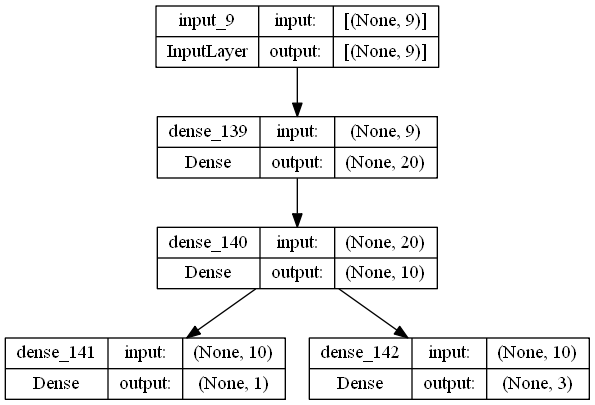

In [100]:
from keras.utils import plot_model

plot_model(model, show_shapes=True)